In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import re
import gc
from tqdm.notebook import trange, tqdm
%matplotlib inline

只运行一百万行代码，速度较快

In [ ]:
nRowsRead = 1000000 # specify 'None' if want to read whole file
# Iowa_Liquor_Sales.csv may have more rows in reality, but we are only loading/previewing the first 10000 rows
df = pd.read_csv('/kaggle/input/iowaliquorsales2020/Iowa_Liquor_Sales.csv',delimiter=',', nrows = nRowsRead,low_memory=False)

#设置norws为None以跑出全部数据，因内存不足而失败。这里尝试使用gc减少内存，还是不行
#df1 = df.copy()
#del df1
#gc.collect()

**若想要运行全部数据，请禁用上面的代码转用下方代码，注意，这里删去了Store Location列，否则会因为内存不足跑不出来**

In [ ]:
useful_columns = ['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
      'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
      'Sale (Dollars)', 'Volume Sold (Liters)','Volume Sold (Gallons)']

# Load raw dataset and sample 10% of it right away:
FILE_NAME = '/kaggle/input/iowaliquorsales2020/Iowa_Liquor_Sales.csv'
df = pd.read_csv(FILE_NAME, parse_dates=['Date'], usecols=useful_columns)

# 内存缩小（暂时禁用，没找到解决办法）

**即使跑出以上全部数据，在后续将object类型统一以及将Store name 拆开时仍然会因为内存不足导致内核挂掉，这里尝试使用kaggler的内核缩减方法进行处理。**

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
df = reduce_mem_usage(df)

内存减少35.9%

# 数据预处理

In [ ]:
df.head()

对于object类型的数据，大小写不一样都会导致不同的结果，为了后期结果稳定，需要统一大小写，以防止出现因大小写不同而导致的结果差异。
查看数据，发现Storename一行数据有些奇怪，其分布大体为商店（连锁店店名）+商店副名（如XX加盟店）+数字

选择将其拆开以便后续任务一：选择商店名称

 **即使运行了kaggler内存缩小代码，下方代码仍然无法跑出全部数据，问题暂时不知道怎么解决**
 
 想运行以下代码请先使用一百万行数据而非全部数据

In [ ]:
def basic_preprocessing(df):
    
    #选取所有为object的数据列
    object_column_list = list(df.dtypes[df.dtypes == object].index)
    
    # 把object类型的列全部转为小写
    for object_column in object_column_list:
        df.loc[:,object_column] = df.loc[:,object_column].str.lower().str.strip().str.split().str.join(' ')
        gc.collect()
    
    # 部分商店名称为商店（或连锁店）+商店后缀（加盟店）+数字，将其拆开
    df[['Store Name','Store Subname']] = df['Store Name'].str.rsplit(pat=" / ", expand=True, n=1)
    df[['Store Name','Store SubNumber']] = df['Store Name'].str.rsplit(pat=" #", expand=True, n=1)
    
    return df

In [ ]:
basic_preprocessing(df)

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
df.head()

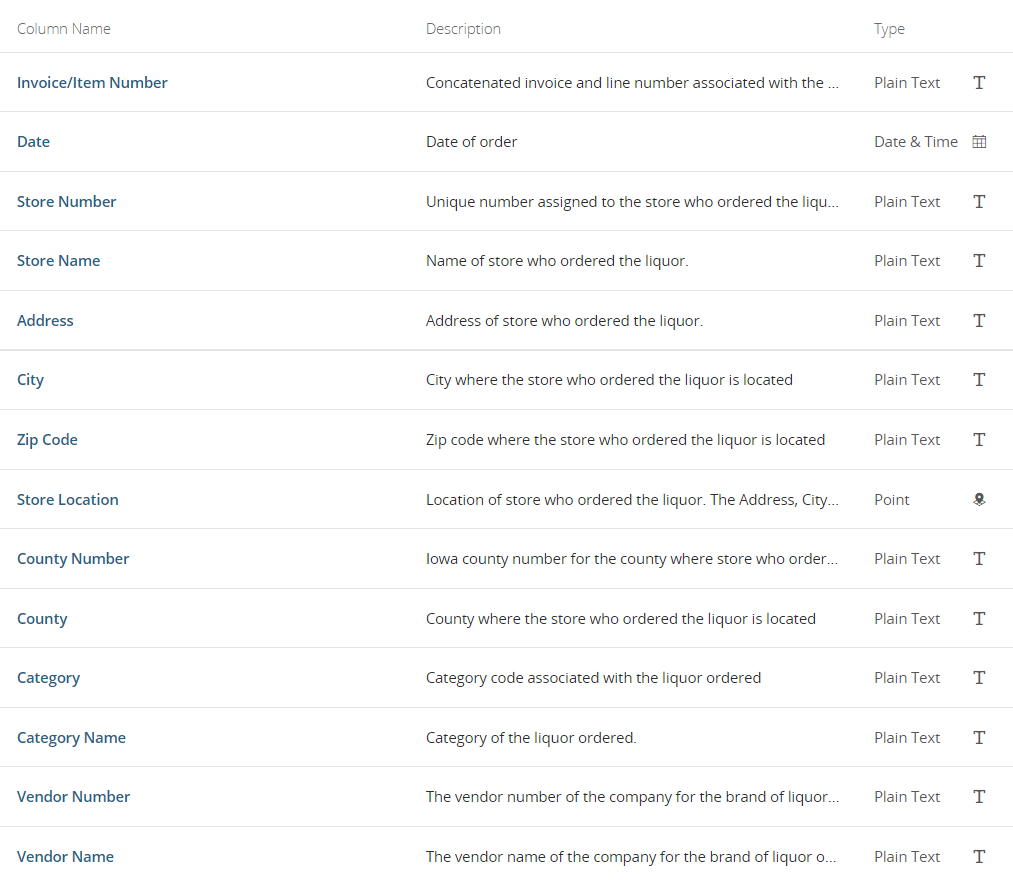

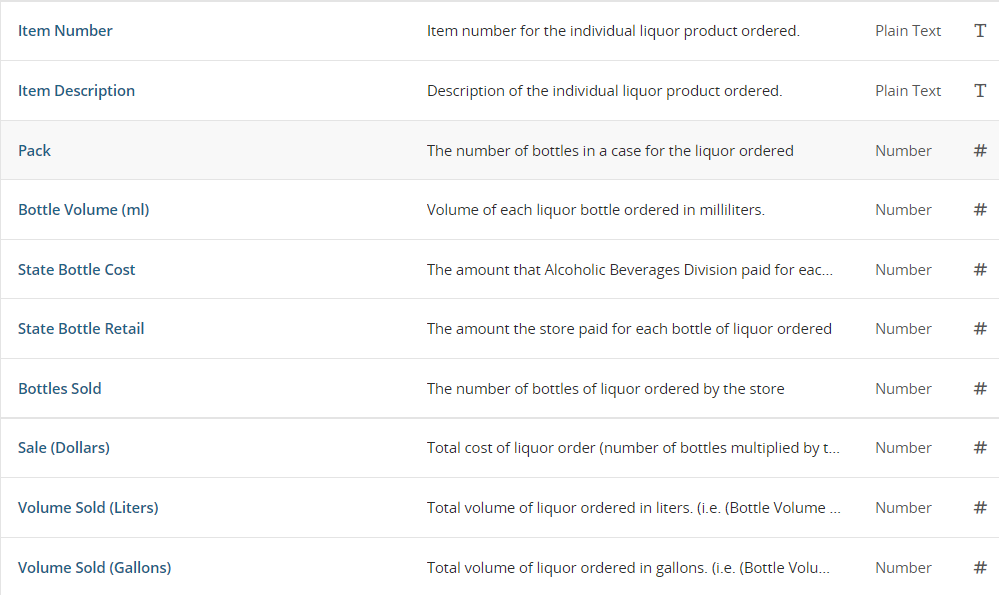

快速查看数据类型

In [ ]:
df.info()

**数据清洗**

**查看有无空值**

In [ ]:
df.isnull().any().sum()

查看空值分布情况

In [ ]:
missing = df.isnull().sum()/len(df)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

In [ ]:
missing.plot.bar()

如果后续分析没有使用坐标位置，那么大部分的空值可以忽略，然而通过查看坐标列信息，发现其数据信息为经纬度坐标轴，后续可以使用tableau的地图功能，所以该列信息比较重要。
尝试弃用storelocation进行后续清洗工作。
同时由于subname和subnumber缺失太多，一并删去。

In [ ]:
df.drop('Store Location',axis = 1,inplace = True)

In [ ]:
df.drop('Store Subname',axis = 1,inplace = True)

In [ ]:
df.drop('Store SubNumber',axis = 1,inplace = True)

In [ ]:
df.shape

查看去掉na后剩余行数

In [ ]:
df.dropna().shape[0]  

In [ ]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

**查看有无重复值**

In [ ]:
df['Invoice/Item Number'].nunique() 

数据无重复

**将数据分为数值特征以及类别特征**

这里发现问题，使用kaggler内存缩小方法会导致所有str类型数据被改写，无奈只能弃用内核缩小方法

In [ ]:
int_data=[]
str_data=[]

for i in range(len(df.iloc[0])):
    if isinstance(df.iloc[0,i],(int,float)):
        int_data.append(df.columns[i])
    else:
        str_data.append(df.columns[i])
        
print(int_data)
print(str_data)

In [ ]:
df['Bottle Volume (ml)'].value_counts(dropna=False).sort_index()

In [ ]:
df['Pack'].value_counts(dropna=False).sort_index()

In [ ]:
df['Bottles Sold'].value_counts(dropna=False).sort_index()

以上三者应属于数值特征，重定向

In [ ]:
for i in ['Bottle Volume (ml)','Bottles Sold','Pack']:
    str_data.remove(i)
    int_data.append(i)

In [ ]:
int_data

In [ ]:
str_data

将数据划分为离散型以及连续型

In [ ]:
a_list=[0,1,2,3,7,9]

numerical_discrete_fea=[]
for i in a_list:
    numerical_discrete_fea.append(int_data[i])

    
numerical_continuous_fea=[]

for i in int_data:
    if i not in numerical_discrete_fea:
        numerical_continuous_fea.append(i)

离散型随机变量如下

In [ ]:
numerical_discrete_fea

连续型随机变量如下

In [ ]:
numerical_continuous_fea

In [ ]:
df_continuous = pd.DataFrame(df,columns = ['Sale (Dollars)','Volume Sold (Liters)','Volume Sold (Gallons)','Bottles Sold'])

In [ ]:
df['Sale (Dollars)'].value_counts()

In [ ]:
df['Bottles Sold'].value_counts()

In [ ]:
plt.hist(df['Sale (Dollars)'])

In [ ]:
plt.boxplot(df['Volume Sold (Liters)'])

In [ ]:
plt.boxplot(df['Volume Sold (Gallons)'])

In [ ]:
plt.boxplot(df['Bottles Sold'])

In [ ]:
df.loc[df['Sale (Dollars)'] > 40000]['Store Name'].value_counts()

In [ ]:
df.loc[df['Volume Sold (Liters)'] > 2000]['Store Name'].value_counts()

In [ ]:
df.loc[df['Volume Sold (Gallons)'] > 800]['Store Name'].value_counts()

In [ ]:
df.loc[df['Bottles Sold'] > 2000]['Store Name'].value_counts()

In [ ]:
#df2 = df.drop(df[df['Sale (Dollars)']>40000].index)

对于连续的一段时间，某间store里某种酒卖的非常好的次数只出现一次，基本可以判断为异常值。建议是删去,问题在于现有异常值的出现可能是因为样本量不足，后续可以使用完整样本查看情况。

对于使用截尾清理异常值的考虑，一个担心是即使采用99%和1%的上下界，仍然可能导致损失过多数据（原样本有1千万行）
此外，由于我们需要预测收入情况以及按照收入、售出数量等特征来选择店铺和产品，个人认为不应该进行分箱。

生成数据报告

In [ ]:
#pfr = pandas_profiling.ProfileReport(df)

In [ ]:
#pfr

In [ ]:
#pfr.to_file("./example.html")

拆分店铺坐标为经纬度，需要先去空值，若不使用storelocation则这一部分跳过

In [ ]:
#df1['Longitude'] = df1['Store Location'].map(lambda x:x.split(' ')[1])
#df1['Latitude'] = df1['Store Location'].map(lambda x:x.split(' ')[2])

In [ ]:
#df1.head(53)

In [ ]:
#for i in range(len(df1['Longitude'])):
#    try:
#        df1['Longitude'][i].replace('(','')
#    except KeyError:
#        pass
#    continue

In [ ]:
#for i in range(len(df1['Latitude'])):
#    try:
#        df1['Latitude'][i].replace(')','')
#    except KeyError:
#        pass
#    continue

In [ ]:
#df1

In [ ]:
#re.sub('[POINT()]','',df['Store Location'][52])

**特征交互**

In [ ]:
df.loc[:,'Sales/Volume(Liters)'] = df['Sale (Dollars)']/df['Volume Sold (Liters)'] #每公升价格

In [ ]:
df.loc[:,'Sales/Volume(Gallons)'] = df['Sale (Dollars)']/df['Volume Sold (Gallons)'] #每加仑价格

In [ ]:
df.loc[:,'Cost(Dollars)'] = df['State Bottle Cost']*df['Bottles Sold'] #总成本

In [ ]:
df.loc[:,'Cost/Volume(Liters)'] = df['Cost(Dollars)']/df['Volume Sold (Liters)'] #每公升成本

In [ ]:
df.loc[:,'Cost/Volume(Gallons)'] = df['Cost(Dollars)']/df['Volume Sold (Gallons)'] #每加仑成本

In [ ]:
df.loc[:,'Bottles Sold/Pack'] = df['Bottles Sold']/df['Pack'] #售出pack数

In [ ]:
df.loc[:,'Pack*State Bottle Cost'] = df['Pack']*df['State Bottle Cost'] #每pack成本

In [ ]:
df.loc[:,'Pack*State Bottle Retail'] = df['Pack']*df['State Bottle Retail'] #每pack收入